# Classical A/B Testing

## Imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy
import scipy.stats as scs

In [65]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plot import *
from stats import *

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

## Reading Data

In [4]:
# reading the csv file
missing_values = ["n/a", "na", "undefined"]
df = pd.read_csv("../data/AdSmartABdata.csv", na_values=missing_values)
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


## Data Cleaning

In [5]:
df.shape

(8077, 9)

In [6]:
temp_df = df.query("not (yes == 0 & no == 0)")
temp_df.shape

(1243, 9)

Only 1243 users out of 8077 responded to the questionaire. So we will drop users who haven't responded.

In [42]:
clean_df = temp_df[['auction_id', 'experiment', 'yes', 'no']]
clean_df['aware'] = 0
clean_df.loc[clean_df['yes'] == 1, 'aware'] = 1
clean_df.loc[clean_df['yes'] == 0, 'aware'] = 0
clean_df.drop(columns=['yes', 'no'], inplace=True)
clean_df = clean_df.set_index('auction_id')
clean_df

,experiment,aware
auction_id,,
0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
00ebf4a8-060f-4b99-93ac-c62724399483,control,0
...,...,...
ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,1
ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,1
ffb79718-6f25-4896-b6b3-e58b80a6e147,control,0


Now since we have merged yes and no columns into aware, we can identify the conversion rates easily.

## Data Summary

In [43]:
summary_df = clean_df.pivot_table( index='experiment', aggfunc='sum')
summary_df['total'] = clean_df.pivot_table( index='experiment', aggfunc='count')
summary_df['rate'] = clean_df.pivot_table( index='experiment')
summary_df['not aware'] = summary_df['total'] - summary_df['aware']
summary_df = summary_df.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
summary_df

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [44]:
exp_rate = summary_df['rate']['exposed']
cont_rate = summary_df['rate']['control']

In [45]:
exp_aware = summary_df['aware']['exposed']
cont_aware = summary_df['aware']['control']

In [46]:
exp_total = summary_df['total']['exposed']
cont_total = summary_df['total']['control']

In [56]:
diff = exp_rate - cont_rate

In [57]:
print(f'The difference between conversion rates of the test and control groups is {diff}.')

The difference between conversion rates of the test and control groups is 0.018285619295484168.


Now we know there is a difference but we aren't confident about the difference. To be confident we will perform hypothesis testing.

## Probability Distributions

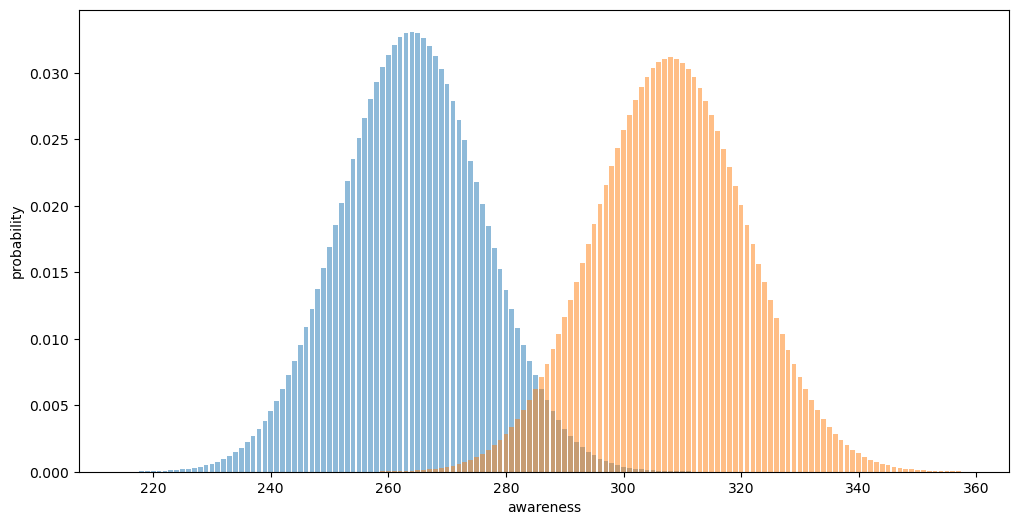

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(cont_aware - 49, cont_aware + 50, 100)
yC = scs.binom(cont_total, cont_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(exp_aware - 49, exp_aware + 50, 100)
yE = scs.binom(exp_total , exp_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()

The distribution in blue is the probability of conversions for the control group while the distribution in orange is the probability of conversions for the exposed group. As we can see there is a difference the mean of the two distributions.

## Distribution of the sample means

In [49]:
# standard error of the mean
SE_C = np.sqrt(cont_rate * (1-cont_rate)) / np.sqrt(cont_total)
SE_E = np.sqrt(exp_rate * (1-exp_rate)) / np.sqrt(exp_total)

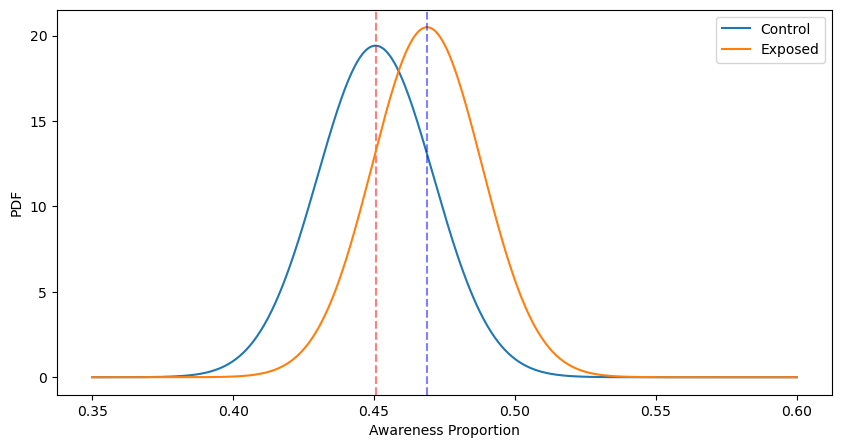

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cont_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cont_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exp_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

The dashed lines pinpoint the mean of the distributions.

In [55]:
std_cont = np.sqrt(cont_rate * (1 - cont_rate) / cont_total)
std_exp = np.sqrt(exp_rate * (1 - exp_rate) / exp_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

## Null hypothesis and Alternative hypothesis

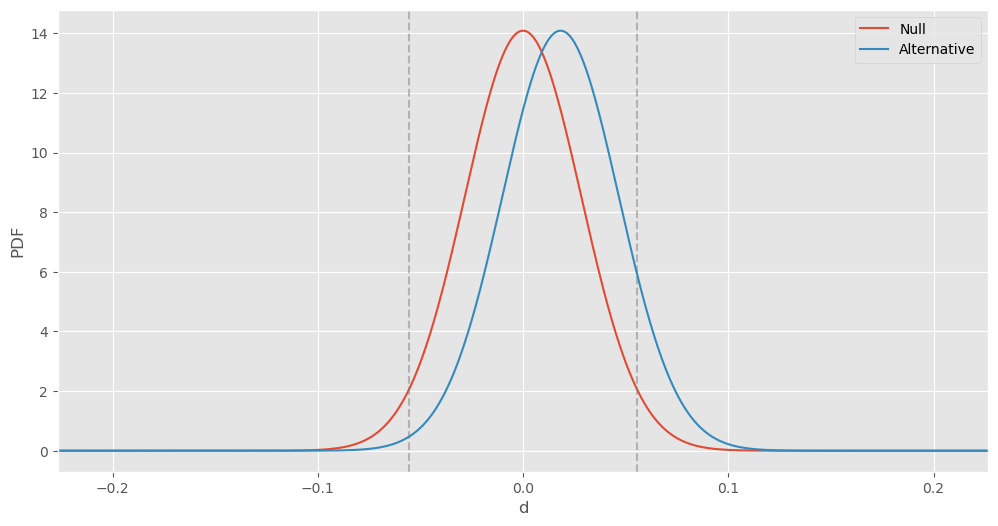

In [59]:
abplot(cont_total, exp_total, cont_rate, diff)

In [61]:
z_score = (diff) / np.sqrt(std_cont**2 + std_exp**2)
p_value = scs.norm().sf(z_score)
z_score, p_value

(0.6458981015684259, 0.2591726745827285)

We can see that the p-value is much greater than the significance level. So we can't be confident about the significance of the lift.

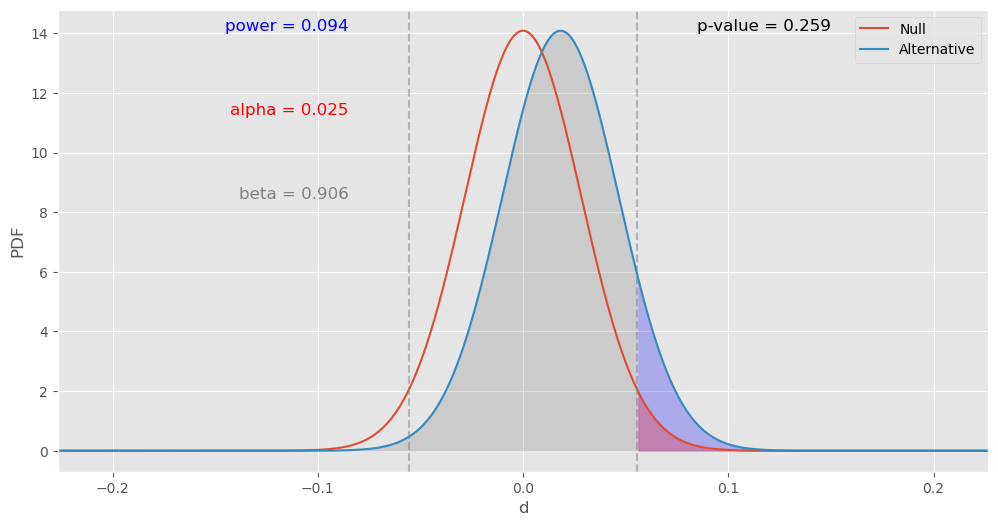

In [62]:
abplot(cont_total, exp_total, cont_rate, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

As we can see the power is around 9.4%, which means there is a high chance of making type-II error.

## Optimal sample size

In [68]:
power = 0.8
sig_level = 0.05
min_sample = round(min_sample_size(cont_rate, diff, power,  sig_level))
print(f'{min_sample} is the minimum sample size to achieve 80% power.')

11661 is the minimum sample size to achieve 80% power.


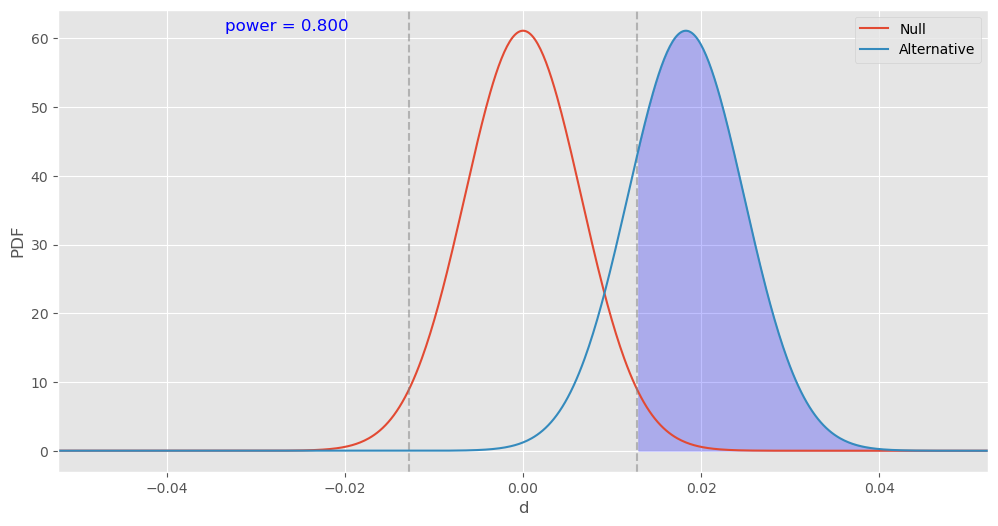

In [69]:
abplot(min_sample, min_sample, cont_rate, diff, show_power=True)

## Reference

1. [The Math Behind A/B Testing with Example Python Code](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)